기업의 가치 평가를 예측하는 과정에서는 Discounted Cash Flow, 줄여서 DCF를 사용한다. 
DCF방식에서 사용하는 기업 잉여현금흐름 (Free Cash Flow to Firm, FCFF)은 기업이 영업을 통해 벌어들인 현금중, 영업활동의 지속을 위한 비용을 제외한 금액으로, 기업의 이해관계자들중 채권자와 주주에게 나누어 줄 수 있는 최종적인 현금 흐름을 뜻한다.

FCFF를 계산하기 위한 과정은 다음과 같다.


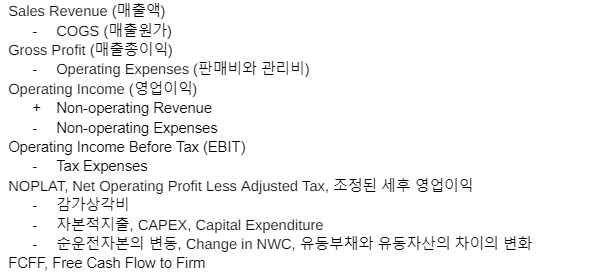

기업이 영업을 계속하기위해서는 이 FCFF가 일정한 수준으로 유지되어야 하며, 이때문에 기업의 폐업을 예측하기 위해서는 FCFF계산에 필요한 항목들이 중요한 역할을 할 것이라 예측을 하고, 이러한 항목들에 대한 XGboost 를 적용하여 폐업에 영향을 주는 항목을 선택 하고자 한다.


FCFF계산식:

FCFF = EBIT(1-t) + Dep - (Change in FA + Change in NWC)



In [ ]:
#plot 한글 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
##코드 실행후 런타임 다시 시작 해야함

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (24.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
#필요한패키지 import

import pandas as pd
import numpy as np
import xgboost as xgb
!pip install unidecode
import unidecode
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix,confusion_matrix, classification_report, roc_auc_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 25.9 MB/s 


In [ ]:
# 드라이브에서 데이터 가져오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


매출액순이익률까지는 결측치도 별로 없고 값들이 정상 범위 안에 위치하나, 수지비율 부터는 %가 계산되는 과정에서 오류가 있는것으로 보임.


In [ ]:
finance = pd.read_csv('/content/drive/MyDrive/Dscover 활동/DScover 2022-2 프로젝트조/메인 프로젝트/챌린지 데이터/finance_4.csv', encoding = 'euc-kr')
print(finance)

       Unnamed: 0       사업자번호          유동자산        매출채권         비유동자산  \
0               1  1018100340  2.070964e+06   143384.75  3.549089e+07   
1               2  1018100772  4.828732e+05         NaN  2.089307e+07   
2               3  1018101126  1.491190e+06   102136.25  3.550742e+07   
3               4  1018101242  5.428135e+05   144011.75  2.465907e+07   
4               5  1018103819  1.667547e+06    48041.25  1.150967e+07   
...           ...         ...           ...         ...           ...   
35704       35705  8998700283  1.008218e+06   494015.00  2.950450e+05   
35705       35706  8998701263  9.025398e+06         NaN           NaN   
35706       35707  8998800150  8.987382e+06  1454567.25  2.287665e+07   
35707       35708  8998800427  7.198705e+06  2728476.25  7.227014e+06   
35708       35709  8998800785  2.024726e+06         NaN  3.424973e+08   

               유형자산          자산총계          유동부채         비유동부채    부..채..총..계  \
0      1.118161e+06  3.756186e+07  5.333542e

In [ ]:
#결측치 채우기
finance = finance.fillna(0)
print(finance)

       Unnamed: 0       사업자번호          유동자산        매출채권         비유동자산  \
0               1  1018100340  2.070964e+06   143384.75  3.549089e+07   
1               2  1018100772  4.828732e+05        0.00  2.089307e+07   
2               3  1018101126  1.491190e+06   102136.25  3.550742e+07   
3               4  1018101242  5.428135e+05   144011.75  2.465907e+07   
4               5  1018103819  1.667547e+06    48041.25  1.150967e+07   
...           ...         ...           ...         ...           ...   
35704       35705  8998700283  1.008218e+06   494015.00  2.950450e+05   
35705       35706  8998701263  9.025398e+06        0.00  0.000000e+00   
35706       35707  8998800150  8.987382e+06  1454567.25  2.287665e+07   
35707       35708  8998800427  7.198705e+06  2728476.25  7.227014e+06   
35708       35709  8998800785  2.024726e+06        0.00  3.424973e+08   

               유형자산          자산총계          유동부채         비유동부채    부..채..총..계  \
0      1.118161e+06  3.756186e+07  5.333542e

In [ ]:
#unnamed 열 삭제하기
finance = finance.drop([finance.columns[0]],axis=1)
print(finance)

            사업자번호          유동자산        매출채권         비유동자산          유형자산  \
0      1018100340  2.070964e+06   143384.75  3.549089e+07  1.118161e+06   
1      1018100772  4.828732e+05        0.00  2.089307e+07  2.088182e+07   
2      1018101126  1.491190e+06   102136.25  3.550742e+07  3.435322e+07   
3      1018101242  5.428135e+05   144011.75  2.465907e+07  2.200939e+07   
4      1018103819  1.667547e+06    48041.25  1.150967e+07  1.108649e+07   
...           ...           ...         ...           ...           ...   
35704  8998700283  1.008218e+06   494015.00  2.950450e+05  2.750500e+04   
35705  8998701263  9.025398e+06        0.00  0.000000e+00  0.000000e+00   
35706  8998800150  8.987382e+06  1454567.25  2.287665e+07  1.850289e+07   
35707  8998800427  7.198705e+06  2728476.25  7.227014e+06  6.594312e+06   
35708  8998800785  2.024726e+06        0.00  3.424973e+08  3.419077e+08   

               자산총계          유동부채         비유동부채    부..채..총..계         자본금  \
0      3.756186e+07  5

In [ ]:
#사업자번호 삭제한 df를 finance_x로 선언하고, 독립변수 X로 설정하기
finance_x = finance.drop([finance.columns[0]],axis=1)
X= finance_x.iloc[:,:-1].copy()
X.head()

,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부..채..총..계,자본금,이익잉여금.결손금.,...,법인세비용차감전순손익,법인세비용,당기순이익.손실.,기업순이익률...,유보액.총자산...,유보액.납입자본...,매출액총이익률...,매출액영업이익률...,매출액순이익률...,수지비율...
0,2070964.50,143384.75,35490892.00,1118160.75,37561856.5,5333541.50,10453503.00,15787044.25,721100.0,4241783.75,...,3875643.25,757435.25,3118208.25,8.07725,5.54400,289.89750,100.00000,6.66200,49.78750,60.74800
1,482873.25,0.00,20893071.75,20881821.75,21375945.0,3142721.25,12042743.75,15185465.00,52000.0,-7922319.25,...,-333442.75,0.00,-333442.75,-0.42500,-33.70475,-13863.74900,24.88600,-51.69050,-76.48600,161.47975
2,1491190.25,102136.25,35507416.50,34353222.50,36998607.0,8974535.25,3180149.00,12154684.00,1539640.0,-3495725.25,...,-353066.50,0.00,-353066.50,-0.26475,-1.61025,-37.91700,41.57100,1.12175,-14.42625,115.17975
3,542813.50,144011.75,24659065.25,22009393.00,25201879.0,6706615.00,2318500.00,9025115.00,450000.0,19692191.25,...,509955.75,97755.50,412200.25,2.43100,86.47050,4841.92225,55.97575,22.04450,14.09375,83.30700
4,1667547.00,48041.25,11509672.25,11086486.50,13177218.5,6715410.00,1568217.75,8283628.00,500000.0,4383956.50,...,440965.25,86017.50,354947.25,3.34275,32.50525,856.78850,100.00000,42.72100,32.39725,61.96825


In [ ]:
#폐업 여부를 종속변수 y 선언하기
y = finance['newcol'].copy()
y.head()


0    0
1    0
2    0
3    0
4    0
Name: newcol, dtype: int64

In [ ]:
sum(y)/len(y)
#폐업비율이 약 19%라는것을 알 수 있음

0.18849589739281414

In [ ]:
#x,y 변수를 train 과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [ ]:
sum(y_train)/len(y_train)
#값이 0.188이 나오면 맞게 나누어진것

0.18849184123072327

In [ ]:
#XGboost 모델 구축하기
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.783422
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.78981
[2]	validation_0-aucpr:0.795793
[3]	validation_0-aucpr:0.796006
[4]	validation_0-aucpr:0.801117
[5]	validation_0-aucpr:0.801977
[6]	validation_0-aucpr:0.801701
[7]	validation_0-aucpr:0.801654
[8]	validation_0-aucpr:0.815925
[9]	validation_0-aucpr:0.817606
[10]	validation_0-aucpr:0.819439
[11]	validation_0-aucpr:0.821296
[12]	validation_0-aucpr:0.821843
[13]	validation_0-aucpr:0.823547
[14]	validation_0-aucpr:0.825959
[15]	validation_0-aucpr:0.825896
[16]	validation_0-aucpr:0.827096
[17]	validation_0-aucpr:0.826843
[18]	validation_0-aucpr:0.828368
[19]	validation_0-aucpr:0.830521
[20]	validation_0-aucpr:0.831946
[21]	validation_0-aucpr:0.832651
[22]	validation_0-aucpr:0.834537
[23]	validation_0-aucpr:0.836531
[24]	validation_0-aucpr:0.836221
[25]	validation_0-aucpr:0.837348
[26]	validation_0-aucpr:0.837447
[27]	validation_0-aucpr:0.838549
[28]	validation_0-auc

XGBClassifier()

1번째 시작한 트리에서는 AUC가 0.77가 나왔으나, 100번째 트리 시도에서는 AUC가 0.862까지 개선된 결과를 보여준다.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


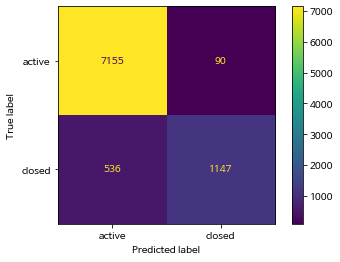

In [ ]:
#모델에 대한 성능평가를 위한 혼동행렬완성하기
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels = ['active', 'closed'])

In [ ]:
#성능평가 결과값
y_pred_probs = clf_xgb.predict(X_test)

In [ ]:
y_preds = [1 if x>0.5 else 0 for x in y_pred_probs]
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
print(roc_auc_score(y_test, y_preds))

[[7155   90]
 [ 536 1147]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7245
           1       0.93      0.68      0.79      1683

    accuracy                           0.93      8928
   macro avg       0.93      0.83      0.87      8928
weighted avg       0.93      0.93      0.93      8928

0.834549366518676


In [ ]:
#plot label 한국어로 설정하기
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

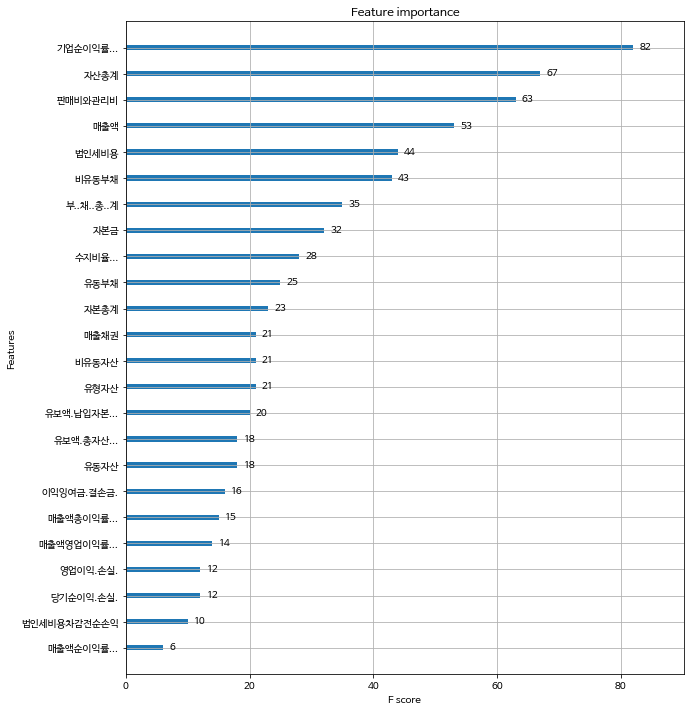

In [ ]:
#feature importance graph
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb, ax=ax)

폐업에 제일 큰 영향을 미치는 항목은 
기업순이익률
자산총계
매출액
매출액총이익률


In [ ]:
#비재무적 요인 xgboost 돌려보기
nonfinance = pd.read_csv('/content/drive/MyDrive/Dscover 활동/DScover 2022-2 프로젝트조/메인 프로젝트/챌린지 데이터/비재무.csv', encoding = 'euc-kr')
print(nonfinance)

        Unnamed: 0      BIZ_NO  operation_date  EMP_CNT  new_col
0                1  1018135422         11352.0     39.0        1
1                2  1018154206          7610.0     17.0        1
2                3  1018163684          6909.0    200.0        1
3                4  1018178760          6466.0      8.0        1
4                5  1018194173          6333.0     22.0        1
...            ...         ...             ...      ...      ...
205478      205479  9903700890          4086.0      NaN        0
205479      205480  9943302894          8905.0      NaN        0
205480      205481  9998100001             NaN     48.0        0
205481      205482  9998100002             NaN     20.0        0
205482      205483  9998100003             NaN    322.0        0

[205483 rows x 5 columns]


In [ ]:
#unnamed 열 삭제하기
nonfinance = nonfinance.drop([nonfinance.columns[0]],axis=1)
print(nonfinance)

            BIZ_NO  operation_date  EMP_CNT  new_col
0       1018135422         11352.0     39.0        1
1       1018154206          7610.0     17.0        1
2       1018163684          6909.0    200.0        1
3       1018178760          6466.0      8.0        1
4       1018194173          6333.0     22.0        1
...            ...             ...      ...      ...
205478  9903700890          4086.0      NaN        0
205479  9943302894          8905.0      NaN        0
205480  9998100001             NaN     48.0        0
205481  9998100002             NaN     20.0        0
205482  9998100003             NaN    322.0        0

[205483 rows x 4 columns]


In [ ]:
#사업자번호 삭제한 df를 finance_x로 선언하고, 독립변수 X로 설정하기
nonfinance_x = nonfinance.drop([nonfinance.columns[0]],axis=1)
X= nonfinance_x.iloc[:,:-1].copy()
X.head()

,operation_date,EMP_CNT
0,11352.0,39.0
1,7610.0,17.0
2,6909.0,200.0
3,6466.0,8.0
4,6333.0,22.0


In [ ]:
#폐업 여부를 종속변수 y 선언하기
y = nonfinance['new_col'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: new_col, dtype: int64

In [ ]:
sum(y)/len(y)
#이번에는 폐업 데이터가 전체의 0.03으로 매우 적다

0.03324849257602819

In [ ]:
#x,y 변수를 train 과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [ ]:
sum(y_train)/len(y_train)

0.033248546511627904

In [ ]:
#XGboost 모델 구축하기
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.077162
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.077364
[2]	validation_0-aucpr:0.077357
[3]	validation_0-aucpr:0.078389
[4]	validation_0-aucpr:0.079499
[5]	validation_0-aucpr:0.081945
[6]	validation_0-aucpr:0.082129
[7]	validation_0-aucpr:0.082571
[8]	validation_0-aucpr:0.082569
[9]	validation_0-aucpr:0.082589
[10]	validation_0-aucpr:0.082224
[11]	validation_0-aucpr:0.082224
[12]	validation_0-aucpr:0.082224
[13]	validation_0-aucpr:0.082259
[14]	validation_0-aucpr:0.08226
[15]	validation_0-aucpr:0.082267
[16]	validation_0-aucpr:0.082267
[17]	validation_0-aucpr:0.08229
[18]	validation_0-aucpr:0.083025
[19]	validation_0-aucpr:0.082987
[20]	validation_0-aucpr:0.083038
[21]	validation_0-aucpr:0.083389
[22]	validation_0-aucpr:0.083365
[23]	validation_0-aucpr:0.083627
[24]	validation_0-aucpr:0.083628
[25]	validation_0-aucpr:0.083594
[26]	validation_0-aucpr:0.084645
[27]	validation_0-aucpr:0.085263
[28]	validation_0-aucp

XGBClassifier()

실행값결과 AUC값이 0.09로 너무 작아 비재무적 요인 단독으로는 사용할 수 없을것 같다. 재무적 요인과 같이 결합해서 사용할 수 있을까?

In [ ]:
#5년 기준으로 폐업 여부 xgboost 예측모델 만들어보기
##5년 이상 영업한 기업의 경우 long 컬럼에 1, 5년 이하의 경우 0으로 표시 
finance = pd.read_csv('/content/drive/MyDrive/Dscover 활동/DScover 2022-2 프로젝트조/메인 프로젝트/챌린지 데이터/finance_5years.csv', encoding = 'euc-kr')
print(finance)

       Unnamed: 0      BIZ_NO          자산총계  operation_date  EMP_CNT  long  \
0               1  1018100340  3.756186e+07         24049.0     41.0   1.0   
1               2  1018100772  2.137594e+07         19341.0      3.0   1.0   
2               3  1018101126  3.699861e+07         20040.0     13.0   1.0   
3               4  1018101242  2.520188e+07         18942.0     17.0   1.0   
4               5  1018103819  1.317722e+07         18946.0      4.0   1.0   
...           ...         ...           ...             ...      ...   ...   
35797       35798  8998700283  1.303263e+06          2147.0      5.0   1.0   
35798       35799  8998701263  9.025398e+06          1172.0      2.0   0.0   
35799       35800  8998800150  3.186404e+07          3962.0    106.0   1.0   
35800       35801  8998800427  1.442572e+07          2283.0     59.0   1.0   
35801       35802  8998800785  3.445220e+08          1841.0      0.0   1.0   

       new_col  
0            0  
1            0  
2           

In [ ]:
#결측치 채우기
finance = finance.fillna(0)
print(finance)

       Unnamed: 0      BIZ_NO          자산총계  operation_date  EMP_CNT  long  \
0               1  1018100340  3.756186e+07         24049.0     41.0   1.0   
1               2  1018100772  2.137594e+07         19341.0      3.0   1.0   
2               3  1018101126  3.699861e+07         20040.0     13.0   1.0   
3               4  1018101242  2.520188e+07         18942.0     17.0   1.0   
4               5  1018103819  1.317722e+07         18946.0      4.0   1.0   
...           ...         ...           ...             ...      ...   ...   
35797       35798  8998700283  1.303263e+06          2147.0      5.0   1.0   
35798       35799  8998701263  9.025398e+06          1172.0      2.0   0.0   
35799       35800  8998800150  3.186404e+07          3962.0    106.0   1.0   
35800       35801  8998800427  1.442572e+07          2283.0     59.0   1.0   
35801       35802  8998800785  3.445220e+08          1841.0      0.0   1.0   

       new_col  
0            0  
1            0  
2           

In [ ]:
#unnamed 열 삭제하기
finance = finance.drop([finance.columns[0]],axis=1)
print(finance)

           BIZ_NO          자산총계  operation_date  EMP_CNT  long  new_col
0      1018100340  3.756186e+07         24049.0     41.0   1.0        0
1      1018100772  2.137594e+07         19341.0      3.0   1.0        0
2      1018101126  3.699861e+07         20040.0     13.0   1.0        0
3      1018101242  2.520188e+07         18942.0     17.0   1.0        0
4      1018103819  1.317722e+07         18946.0      4.0   1.0        0
...           ...           ...             ...      ...   ...      ...
35797  8998700283  1.303263e+06          2147.0      5.0   1.0        1
35798  8998701263  9.025398e+06          1172.0      2.0   0.0        1
35799  8998800150  3.186404e+07          3962.0    106.0   1.0        0
35800  8998800427  1.442572e+07          2283.0     59.0   1.0        0
35801  8998800785  3.445220e+08          1841.0      0.0   1.0        0

[35802 rows x 6 columns]


In [ ]:
#사업자번호 삭제한 df를 finance_x로 선언하고, 독립변수 X로 설정하기
finance_x = finance.drop([finance.columns[0]],axis=1)
X= finance_x.iloc[:,:-1].copy()
X.head()

,자산총계,operation_date,EMP_CNT,long
0,37561856.5,24049.0,41.0,1.0
1,21375945.0,19341.0,3.0,1.0
2,36998607.0,20040.0,13.0,1.0
3,25201879.0,18942.0,17.0,1.0
4,13177218.5,18946.0,4.0,1.0


In [ ]:
#폐업 여부를 종속변수 y 선언하기
y = finance['new_col'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: new_col, dtype: int64

In [ ]:
sum(y)/len(y)
#폐업비율이 약 19%라는것을 알 수 있음

0.19060387687838667

In [ ]:
#x,y 변수를 train 과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [ ]:
sum(y_train)/len(y_train)
#값이 0.1906이 나오면 맞게 나누어진것

0.1906074261666232

In [ ]:
#XGboost 모델 구축하기
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.771568
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.778819
[2]	validation_0-aucpr:0.78173
[3]	validation_0-aucpr:0.78851
[4]	validation_0-aucpr:0.795372
[5]	validation_0-aucpr:0.795231
[6]	validation_0-aucpr:0.806342
[7]	validation_0-aucpr:0.806182
[8]	validation_0-aucpr:0.807222
[9]	validation_0-aucpr:0.808821
[10]	validation_0-aucpr:0.810303
[11]	validation_0-aucpr:0.810665
[12]	validation_0-aucpr:0.812909
[13]	validation_0-aucpr:0.813698
[14]	validation_0-aucpr:0.817421
[15]	validation_0-aucpr:0.820263
[16]	validation_0-aucpr:0.820981
[17]	validation_0-aucpr:0.821063
[18]	validation_0-aucpr:0.824302
[19]	validation_0-aucpr:0.824724
[20]	validation_0-aucpr:0.825828
[21]	validation_0-aucpr:0.82606
[22]	validation_0-aucpr:0.825955
[23]	validation_0-aucpr:0.826869
[24]	validation_0-aucpr:0.827061
[25]	validation_0-aucpr:0.827757
[26]	validation_0-aucpr:0.828031
[27]	validation_0-aucpr:0.828118
[28]	validation_0-aucpr

XGBClassifier()

AUC가 0.771로 시작하여 마지막에는 0.836057까지 향상되는 모습을 보여줌

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


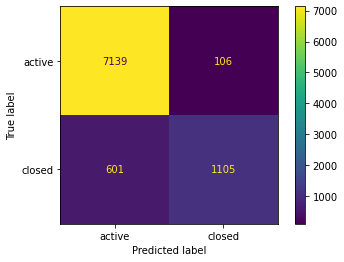

In [ ]:
#모델에 대한 성능평가를 위한 혼동행렬완성하기
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels = ['active', 'closed'])

In [ ]:
#성능평가 결과값
y_pred_probs = clf_xgb.predict(X_test)
y_preds = [1 if x>0.5 else 0 for x in y_pred_probs]
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
print(roc_auc_score(y_test, y_preds))

[[7139  106]
 [ 601 1105]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7245
           1       0.91      0.65      0.76      1706

    accuracy                           0.92      8951
   macro avg       0.92      0.82      0.86      8951
weighted avg       0.92      0.92      0.92      8951

0.8165415854569227


In [ ]:
#plot label 한국어로 설정하기
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

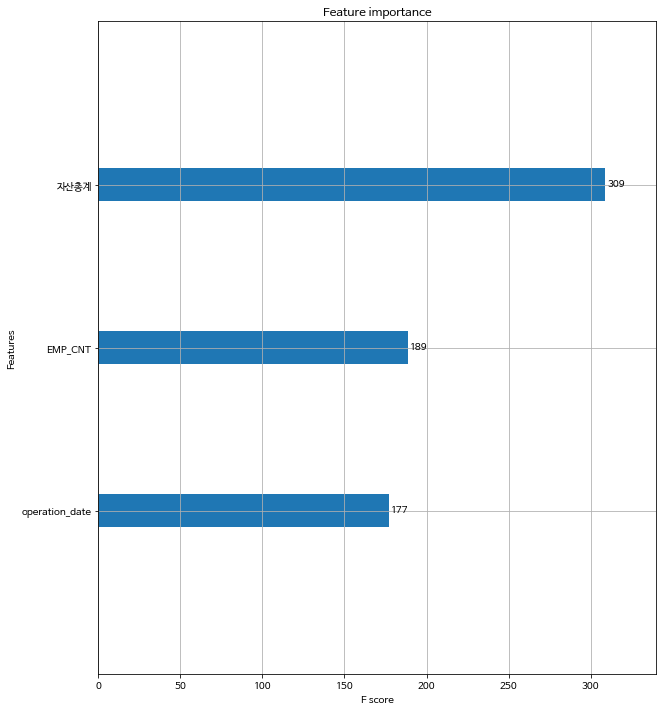

In [ ]:
#feature importance graph
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb, ax=ax)

XGboost 에서 Fscore는 tree를 분할할때 특정 feature가 얼마나 자주 사용되었는지 보여주는 지표이다. 100% 백분율로 중요도를 보고 싶으면 특정 feature Fscore / 전체 Fscore 총합을 계산하면 된다.
EMP_CNT와 Operation_date의 Fscore 백분위는 각각 0.28, 0.26이다.
5년이상인 long column은 아예 사용되지 않은듯 하다.


In [ ]:
#온실가스를 넣어서 재무 데이터와 같이 xgboost 해보기

finance = pd.read_csv('/content/drive/MyDrive/Dscover 활동/DScover 2022-2 프로젝트조/메인 프로젝트/챌린지 데이터/gas_2020.csv', encoding = 'euc-kr')
print(finance)

     Unnamed: 0      BIZ_NO     Co2  Energy         유동자산         매출채권  \
0             1  3048127782   17866     364    468146.00   157647.000   
1             2  5968700856   17774     357     83378.00    35100.000   
2             3  1208157354   23957     447   6151443.00  2356099.333   
3             4  7798600056   14899     303     16698.00    29884.000   
4             5  8618100267   10657     157      2666.00          NaN   
..          ...         ...     ...     ...          ...          ...   
150         151  1398136746   76844      59   5634070.50  1641873.250   
151         152  3178509435  190062     177   8739880.00  3767964.000   
152         153  5068104518  232429     357  21105411.25  3554225.750   
153         154  3108113342   88535    1817  34225030.50  4771657.000   
154         155  3168113317   31024     143   6642162.00  1135429.250   

            비유동자산          유형자산          자산총계          유동부채  ...  \
0    7.630300e+04  6.195700e+04  5.444490e+05  1.403400

In [ ]:
#결측치 채우기
finance = finance.fillna(0)
print(finance)

     Unnamed: 0      BIZ_NO     Co2  Energy         유동자산         매출채권  \
0             1  3048127782   17866     364    468146.00   157647.000   
1             2  5968700856   17774     357     83378.00    35100.000   
2             3  1208157354   23957     447   6151443.00  2356099.333   
3             4  7798600056   14899     303     16698.00    29884.000   
4             5  8618100267   10657     157      2666.00        0.000   
..          ...         ...     ...     ...          ...          ...   
150         151  1398136746   76844      59   5634070.50  1641873.250   
151         152  3178509435  190062     177   8739880.00  3767964.000   
152         153  5068104518  232429     357  21105411.25  3554225.750   
153         154  3108113342   88535    1817  34225030.50  4771657.000   
154         155  3168113317   31024     143   6642162.00  1135429.250   

            비유동자산          유형자산          자산총계          유동부채  ...  \
0    7.630300e+04  6.195700e+04  5.444490e+05  1.403400

In [ ]:
#unnamed 열 삭제하기
finance = finance.drop([finance.columns[0]],axis=1)
print(finance)

         BIZ_NO     Co2  Energy         유동자산         매출채권         비유동자산  \
0    3048127782   17866     364    468146.00   157647.000  7.630300e+04   
1    5968700856   17774     357     83378.00    35100.000  2.000000e+04   
2    1208157354   23957     447   6151443.00  2356099.333  2.013908e+07   
3    7798600056   14899     303     16698.00    29884.000  8.780000e+03   
4    8618100267   10657     157      2666.00        0.000  4.081000e+05   
..          ...     ...     ...          ...          ...           ...   
150  1398136746   76844      59   5634070.50  1641873.250  2.996995e+07   
151  3178509435  190062     177   8739880.00  3767964.000  7.687556e+07   
152  5068104518  232429     357  21105411.25  3554225.750  1.348696e+08   
153  3108113342   88535    1817  34225030.50  4771657.000  1.604604e+07   
154  3168113317   31024     143   6642162.00  1135429.250  1.794304e+07   

             유형자산          자산총계          유동부채         비유동부채  ...  \
0    6.195700e+04  5.444490e+05

In [ ]:
#사업자번호 삭제한 df를 finance_x로 선언하고, 독립변수 X로 설정하기
finance_x = finance.drop([finance.columns[0]],axis=1)
X= finance_x.iloc[:,:-1].copy()
X.head()

,Co2,Energy,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부채총계,...,법인세비용,당기순이익(손실),기업순이익률,유보액/총자산(%),유보액/납입자본(%),매출액총이익률(%),매출액영업이익률(%),매출액순이익률(%),수지비율(%),경상수지비율(%)
0,17866,364,468146.0,157647.000,76303.00,6.195700e+04,5.444490e+05,1.403400e+04,318829.000,3.328630e+05,...,0.0,4.858700e+04,1.000000e+12,29.679000,323.172000,27.288000,6.281000,10.190,90.416000,1.000000e+12
1,17774,357,83378.0,35100.000,20000.00,0.000000e+00,1.033780e+05,6.912000e+03,0.000,6.912000e+03,...,0.0,5.099000e+03,3.856000e+00,-3.419000,-3.534000,67.109000,7.945000,7.945,92.055000,7.378200e+01
2,23957,447,6151443.0,2356099.333,20139076.33,1.956835e+07,2.629052e+07,3.880660e+07,5002665.333,4.380927e+07,...,0.0,-5.213009e+06,-1.447000e+01,-70.918667,-2123.239000,-8.365667,-15.762667,-28.842,128.822667,3.330000e+11
3,14899,303,16698.0,29884.000,8780.00,1.843333e+03,2.547833e+04,1.802987e+05,0.000,1.802987e+05,...,0.0,-3.219767e+04,3.330000e+11,-18468.017000,-254.820333,8.085333,-42.500000,-41.111,142.338667,6.670000e+11
4,10657,157,2666.0,0.000,408100.00,0.000000e+00,4.107660e+05,9.064200e+04,57000.000,1.476420e+05,...,0.0,7.591400e+04,1.000000e+12,51.885000,426.248000,33.674000,13.483000,22.243,79.639000,1.000000e+12


In [ ]:
##scale 하기
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler_fit = scaler.fit(X)
X_scaled = scaler_fit.transform(X)

In [ ]:
#폐업 여부를 종속변수 y 선언하기
y = finance['폐업여부'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: 폐업여부, dtype: int64

In [ ]:
sum(y)/len(y)
#이번에는 약 8%의 폐업데이터

0.08387096774193549

In [ ]:
#x,y 변수를 train 과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y)

In [ ]:
#XGboost 모델 구축하기
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.491564
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.491564
[2]	validation_0-aucpr:0.531937
[3]	validation_0-aucpr:0.531937
[4]	validation_0-aucpr:0.531937
[5]	validation_0-aucpr:0.523617
[6]	validation_0-aucpr:0.531937
[7]	validation_0-aucpr:0.523617
[8]	validation_0-aucpr:0.595456
[9]	validation_0-aucpr:0.572244
[10]	validation_0-aucpr:0.595456
[11]	validation_0-aucpr:0.595456
[12]	validation_0-aucpr:0.629015
[13]	validation_0-aucpr:0.595456
[14]	validation_0-aucpr:0.595456
[15]	validation_0-aucpr:0.595456
[16]	validation_0-aucpr:0.595456
[17]	validation_0-aucpr:0.595456
[18]	validation_0-aucpr:0.595456
[19]	validation_0-aucpr:0.776122
[20]	validation_0-aucpr:0.776122
[21]	validation_0-aucpr:0.776122
[22]	validation_0-aucpr:0.776122
[23]	validation_0-aucpr:0.851238
[24]	validation_0-aucpr:0.851238
[25]	validation_0-aucpr:0.851238
[26]	validation_0-aucpr:0.851238
[27]	validation_0-aucpr:0.851238
[28]	validation_0-au

XGBClassifier()

AUC: 0.851

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


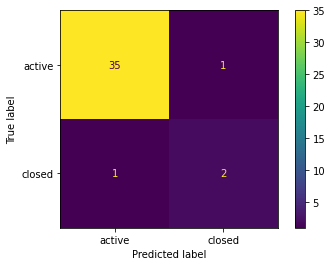

In [ ]:
#모델에 대한 성능평가를 위한 혼동행렬완성하기
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels = ['active', 'closed'])

In [ ]:
#성능평가 결과값
y_pred_probs = clf_xgb.predict(X_test)
y_preds = [1 if x>0.5 else 0 for x in y_pred_probs]
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
print(roc_auc_score(y_test, y_preds))

[[35  1]
 [ 1  2]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.67      0.67      0.67         3

    accuracy                           0.95        39
   macro avg       0.82      0.82      0.82        39
weighted avg       0.95      0.95      0.95        39

0.8194444444444444


In [ ]:
#plot label 한국어로 설정하기
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

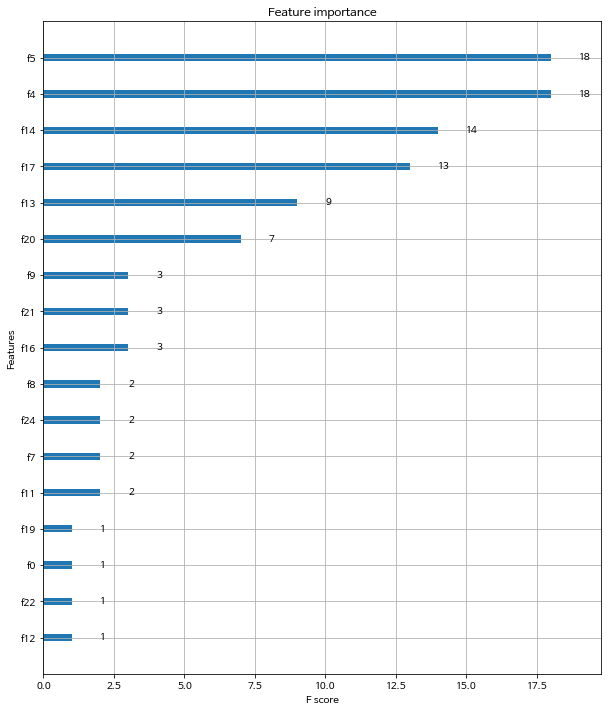

In [ ]:
#feature importance graph
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb, ax=ax)

In [ ]:
X.columns

Index(['Co2', 'Energy', '유동자산', '매출채권', '비유동자산', '유형자산', '자산총계', '유동부채',
       '비유동부채', '부채총계', '자본금', '이익잉여금(결손금)', '자본총계', '매출액', '판매비와관리비',
       '영업이익(손실)', '법인세비용차감전순손익', '법인세비용', '당기순이익(손실)', '기업순이익률', '유보액/총자산(%)',
       '유보액/납입자본(%)', '매출액총이익률(%)', '매출액영업이익률(%)', '매출액순이익률(%)', '수지비율(%)',
       '경상수지비율(%)'],
      dtype='object')

Feature Importance 순서 (F0부터)
F5 = 유형자산
F4 = 비유동자산
F14 = 판매비와관리비
F17 = 법인세비용
F13 = 매출액


In [ ]:
#중요한 재무항목만 넣어서 다시 돌려보기
finance = finance[['Co2', 'Energy', '유형자산', '비유동자산','판매비와관리비','법인세비용','매출액','폐업여부']]

In [ ]:
X= finance.iloc[:,:-1].copy()
X.head()


,Co2,Energy,유형자산,비유동자산,판매비와관리비,법인세비용,매출액
0,17866,364,6.195700e+04,76303.00,100161.0,0.0,476805.00
1,17774,357,0.000000e+00,20000.00,37973.0,0.0,64182.00
2,23957,447,1.956835e+07,20139076.33,1349098.0,0.0,18291579.33
3,14899,303,1.843333e+03,8780.00,57679.0,0.0,201054.00
4,10657,157,0.000000e+00,408100.00,68910.0,0.0,341300.00


In [ ]:
scaler = MinMaxScaler()
scaler_fit = scaler.fit(X)
X_scaled = scaler_fit.transform(X)

In [ ]:
#폐업 여부를 종속변수 y 선언하기
y = finance['폐업여부'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: 폐업여부, dtype: int64

In [ ]:
#x,y 변수를 train 과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y)

In [ ]:
#XGboost 모델 구축하기
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.702787
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.702787
[2]	validation_0-aucpr:0.702787
[3]	validation_0-aucpr:0.700614
[4]	validation_0-aucpr:0.700614
[5]	validation_0-aucpr:0.700614
[6]	validation_0-aucpr:0.718708
[7]	validation_0-aucpr:0.724045
[8]	validation_0-aucpr:0.724045
[9]	validation_0-aucpr:0.720316
[10]	validation_0-aucpr:0.724045
[11]	validation_0-aucpr:0.728337
[12]	validation_0-aucpr:0.724045
[13]	validation_0-aucpr:0.728337
[14]	validation_0-aucpr:0.724045
[15]	validation_0-aucpr:0.728337
[16]	validation_0-aucpr:0.733333
[17]	validation_0-aucpr:0.733333
[18]	validation_0-aucpr:0.733333
[19]	validation_0-aucpr:0.742173
[20]	validation_0-aucpr:0.742173
[21]	validation_0-aucpr:0.742173
[22]	validation_0-aucpr:0.742173
[23]	validation_0-aucpr:0.742173
[24]	validation_0-aucpr:0.742173
[25]	validation_0-aucpr:0.742173
[26]	validation_0-aucpr:0.742173
[27]	validation_0-aucpr:0.742173
[28]	validation_0-au

XGBClassifier()

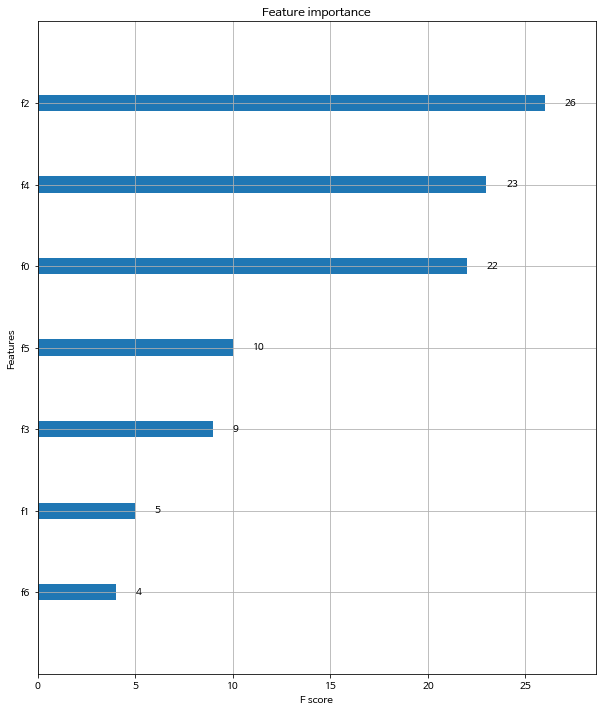

In [ ]:
#feature importance graph
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb, ax=ax)

In [ ]:
X.columns

Index(['Co2', 'Energy', '유형자산', '비유동자산', '판매비와관리비', '법인세비용', '매출액'], dtype='object')

중요순서 (F0부터)
F2 = 유형자산
F4 = 판매비와관리비
F0 = Co2
F5 = 법인세비용
F3 = 비유동자산
F1 = Energy
Co2 + Energy가 전체 feature importacne의 27%를 차지함.

In [ ]:
###### 추가적으로 모델 발전 시키기
finance = pd.read_csv('/content/drive/MyDrive/Dscover 활동/DScover 2022-2 프로젝트조/메인 프로젝트/챌린지 데이터/final_kdn.csv', encoding = 'euc-kr')
print(finance)

    Unnamed: 0       사업자번호         유동자산         매출채권         비유동자산  \
0            1  1058128980  13708106.00  2145646.000  5.493762e+06   
1            2  1078174705   6855731.00  1096013.250  9.038887e+06   
2            3  1078174705   6855731.00  1096013.250  9.038887e+06   
3            4  1198121822  22867743.75  6687359.500  5.685671e+06   
4            5  1198127199   7437399.25  1596302.000  5.149450e+06   
..         ...         ...          ...          ...           ...   
65          66  6138157161    110482.00    32045.000  2.094023e+06   
66          67  6178109190  31679548.50  7622579.750  1.590358e+07   
67          68  6218166318   8913921.00  5831984.667  2.020787e+06   
68          69  6218166318   8913921.00  5831984.667  2.020787e+06   
69          70  6228113532   9086347.00  2680158.000  2.781411e+06   

            유형자산         자산총계         유동부채        비유동부채         부채총계  ...  \
0   1.638377e+06  19201868.33  12642507.67  1804783.333  14447291.00  ...   
1   6

In [ ]:
#결측치 채우기
finance = finance.fillna(0)
print(finance)

    Unnamed: 0       사업자번호         유동자산         매출채권         비유동자산  \
0            1  1058128980  13708106.00  2145646.000  5.493762e+06   
1            2  1078174705   6855731.00  1096013.250  9.038887e+06   
2            3  1078174705   6855731.00  1096013.250  9.038887e+06   
3            4  1198121822  22867743.75  6687359.500  5.685671e+06   
4            5  1198127199   7437399.25  1596302.000  5.149450e+06   
..         ...         ...          ...          ...           ...   
65          66  6138157161    110482.00    32045.000  2.094023e+06   
66          67  6178109190  31679548.50  7622579.750  1.590358e+07   
67          68  6218166318   8913921.00  5831984.667  2.020787e+06   
68          69  6218166318   8913921.00  5831984.667  2.020787e+06   
69          70  6228113532   9086347.00  2680158.000  2.781411e+06   

            유형자산         자산총계         유동부채        비유동부채         부채총계  ...  \
0   1.638377e+06  19201868.33  12642507.67  1804783.333  14447291.00  ...   
1   6

In [ ]:
#unnamed 열 삭제하기
finance = finance.drop([finance.columns[0]],axis=1)
print(finance)

         사업자번호         유동자산         매출채권         비유동자산          유형자산  \
0   1058128980  13708106.00  2145646.000  5.493762e+06  1.638377e+06   
1   1078174705   6855731.00  1096013.250  9.038887e+06  6.174718e+06   
2   1078174705   6855731.00  1096013.250  9.038887e+06  6.174718e+06   
3   1198121822  22867743.75  6687359.500  5.685671e+06  2.712668e+05   
4   1198127199   7437399.25  1596302.000  5.149450e+06  1.858929e+06   
..         ...          ...          ...           ...           ...   
65  6138157161    110482.00    32045.000  2.094023e+06  2.094023e+06   
66  6178109190  31679548.50  7622579.750  1.590358e+07  1.125352e+07   
67  6218166318   8913921.00  5831984.667  2.020787e+06  8.366467e+05   
68  6218166318   8913921.00  5831984.667  2.020787e+06  8.366467e+05   
69  6228113532   9086347.00  2680158.000  2.781411e+06  1.011193e+06   

           자산총계         유동부채        비유동부채         부채총계           자본금  ...  \
0   19201868.33  12642507.67  1804783.333  14447291.00  1.

In [ ]:
##산업코드 지우기 (final 파일 일때만)
finance = finance.drop('산업코드_eng', axis=1)

In [ ]:
#사업자번호 삭제한 df를 finance_x로 선언하고, 독립변수 X로 설정하기
finance_x = finance.drop([finance.columns[0]],axis=1)
X= finance_x.iloc[:,:-1].copy()
X.head()


,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부채총계,자본금,이익잉여금.결손금.,...,상병보상연금,장해급여,유족급여,장의비,간병급여,재활급여,코스닥_회사수,코스닥_상장주식수,코스닥_시가총액,제재번호
0,13708106.00,2145646.00,5493762.333,1638377.333,19201868.33,12642507.67,1804783.333,14447291.00,1200000.0,6.399079e+06,...,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,1
1,6855731.00,1096013.25,9038887.000,6174718.250,15894618.00,1321723.50,2062659.750,3384383.00,1500000.0,1.088987e+07,...,0,0.000000e+00,0.000000e+00,0,0,0,95,2261407,42359450,4
2,6855731.00,1096013.25,9038887.000,6174718.250,15894618.00,1321723.50,2062659.750,3384383.00,1500000.0,1.088987e+07,...,0,0.000000e+00,0.000000e+00,0,0,0,95,2261407,42359450,4
3,22867743.75,6687359.50,5685671.000,271266.750,28553414.50,6040131.00,8402.750,6048533.50,1500000.0,2.102095e+07,...,34058499300,7.680000e+11,1.960000e+11,7491076220,14552762320,7556469810,954,26138635,240921707,3
4,7437399.25,1596302.00,5149449.500,1858929.250,12586849.00,2643522.00,224758.750,2868280.75,320000.0,9.378588e+06,...,42540003410,7.430000e+11,2.070000e+11,9814404680,17934462750,7349724790,25,902812,3266251,1


In [ ]:
X.columns

Index(['유동자산', '매출채권', '비유동자산', '유형자산', '자산총계', '유동부채', '비유동부채', '부채총계', '자본금',
       '이익잉여금.결손금.', '자본총계', '매출액', '판매비와관리비', '영업이익.손실.', '법인세비용차감전순손익',
       '법인세비용', '당기순이익.손실.', '기업순이익률', '유보액.총자산...', '유보액.납입자본...',
       '매출액총이익률...', '매출액영업이익률...', '매출액순이익률...', '수지비율...', '경상수지비율...',
       '영업비율...', '금융비용대매출액비율...', '금융비용대부채비율...', '금융비용대총비용비율...', '부채비율...',
       '차입금의존도...', '자기자본비율...', '순운전자본비율...', '유동부채비율...', '비유동부채비율...',
       '부채총계대매출액...', '총자본회전율.회.', '재고자산회전율.회.', '매출채권회전율.회.', '매입채무회전율.회.',
       '미수금', '매출원가', '무형자산', '재고자산', '산업코드', '폐업여부', '고용허가제.외국인근로자.도입',
       '산재신청.승인율', '요양급여', '휴업급여', '상병보상연금', '장해급여', '유족급여', '장의비', '간병급여',
       '재활급여', '코스닥_회사수', '코스닥_상장주식수', '코스닥_시가총액', '제재번호'],
      dtype='object')

In [ ]:
##scale 하기
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler_fit = scaler.fit(X)
X_scaled = scaler_fit.transform(X)

In [ ]:
#폐업 여부를 종속변수 y 선언하기
y = finance['폐업여부'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: 폐업여부, dtype: int64

In [ ]:
sum(y)/len(y)
#폐업 데이터 비율 확인, 이번에는 약 18%의 폐업데이터

0.18571428571428572

In [ ]:
#x,y 변수를 train 과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y)

In [ ]:
#XGboost 모델 구축하기
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:1
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:1
[2]	validation_0-aucpr:1
[3]	validation_0-aucpr:1
[4]	validation_0-aucpr:1
[5]	validation_0-aucpr:1
[6]	validation_0-aucpr:1
[7]	validation_0-aucpr:1
[8]	validation_0-aucpr:1
[9]	validation_0-aucpr:1
[10]	validation_0-aucpr:1
Stopping. Best iteration:
[0]	validation_0-aucpr:1



XGBClassifier()

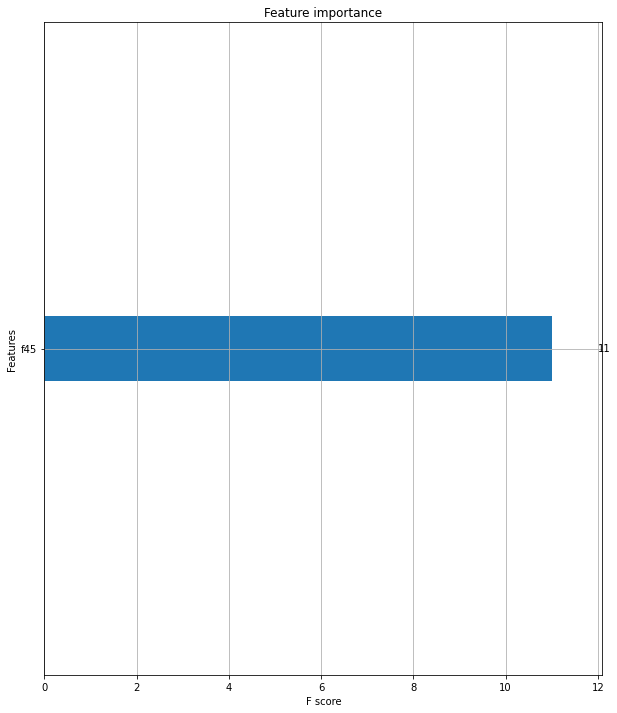

In [ ]:
#feature importance graph
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb, ax=ax)